# stocks price prediction using LSTM
this project is part of my course work at Karatina University, empasizes the use of artificial Intelligence specifically LSTM RNN architecture for predicting the prices of stocks. 

## importing of libralies

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import joblib
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


2023-05-11 05:57:49.066321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 05:57:49.208971: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-11 05:57:49.208994: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-11 05:57:49.917900: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## fetching data from yahoo finance using pandas_datareader


In [5]:
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()


end = datetime.now()
end = end - timedelta(weeks=10)
start = datetime(end.year - 10, end.month, end.day)


def get_data(ticker, start, end):
    df = pdr.get_data_yahoo(ticker, start, end)
    return df
df = get_data('AAPL', start, end)
print(df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed
(2517, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-03-04,15.278571,15.292857,14.964286,15.001786,12.956762,582755600
2013-03-05,15.052857,15.542500,15.026786,15.397857,13.298839,638433600
2013-03-06,15.518214,15.544643,15.158214,15.202143,13.129807,460250000
2013-03-07,15.160714,15.428929,15.037857,15.377857,13.281566,468473600
2013-03-08,15.350000,15.551071,15.307500,15.418571,13.316730,391482000


## Describing the data statistically
Through this we are able to see the destribution of our data i.e., standard deviation along the mean and other useful insights

In [28]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,64.395385,65.130243,63.691418,64.440035,62.603707,1.633913e+08
std,49.366029,50.022464,48.734355,49.406898,49.900580,1.115887e+08
min,13.856071,14.271429,13.753571,13.947500,12.046190,3.519590e+07
25%,27.375000,27.625000,27.132500,27.372499,25.116194,9.000920e+07
50%,42.599998,42.962502,42.255001,42.602501,40.615101,1.277524e+08
75%,113.205002,115.230003,110.889999,112.820000,111.120071,1.989904e+08
max,182.630005,182.940002,179.119995,182.009995,180.683853,1.065523e+09


## Infor about the data
We are able to visualize the formats of the data, all our data is in the correct format

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-03-04 to 2023-03-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


## Plotting the (closing price and Volume) for this symbol against time 

/tmp/ipykernel_37935/2534222005.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  top_plt = plt.subplot2grid((6, 4), (0, 0), rowspan=3, colspan=4)


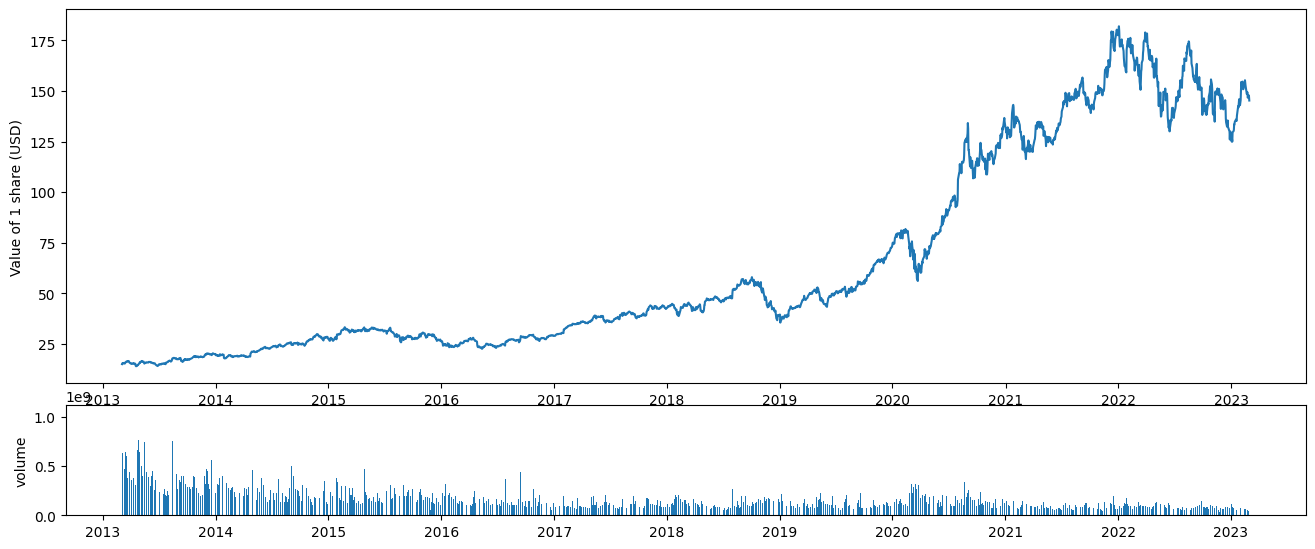

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize=(16, 10))
plt.title("AAPL (Apple stocks)")
top_plt = plt.subplot2grid((6, 4), (0, 0), rowspan=3, colspan=4)
top_plt.set_ylabel("Value of 1 share (USD)")
top_plt.plot(df.index, df['Close'])
bottom_plt = plt.subplot2grid((6, 4), (3, 0), rowspan=1, colspan=4)
bottom_plt.bar(df.index, df['Volume'])
bottom_plt.set_ylabel("volume")
plt.show()
plt.tight_layout()


## feature selection
This involves using Closing price and dropping other collumns

In [6]:
data = df.filter(['Close'])
dataset = data.values

training_data_len = int(len(dataset) * 0.8 )
testing_data_len = len(dataset) - training_data_len
print("dataset shape -",dataset.shape)
print("training data length -",training_data_len)

dataset shape - (2517, 1)
training data length - 2013


## Data Normalization
This involves scalling the data into a 0-1 range

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)
print(dataset.shape)
scaled.shape

(2517, 1)


(2517, 1)

## Creating training dataset

In [8]:

train_data = scaled[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[array([0.00627318, 0.00862986, 0.00746533, 0.00851086, 0.00875312,
       0.01006003, 0.00805397, 0.00803697, 0.00891888, 0.01129044,
       0.01385327, 0.01359189, 0.01307974, 0.01321787, 0.01516868,
       0.01552356, 0.01500505, 0.01307974, 0.01107794, 0.00815598,
       0.00834298, 0.0088105 , 0.00790309, 0.00694257, 0.00758221,
       0.00774584, 0.00959677, 0.00930777, 0.00834511, 0.00623068,
       0.00758859, 0.00260744, 0.00032301, 0.        , 0.00172979,
       0.0033151 , 0.00317271, 0.00379323, 0.00566753, 0.00841311,
       0.01110343, 0.01036179, 0.01168571, 0.01263348, 0.01491368,
       0.01447803, 0.01557881, 0.01407639, 0.01326887, 0.013645  ,
       0.01133295, 0.00814322, 0.00936088, 0.00908038, 0.01113531,
       0.01044042, 0.01079955, 0.01096743, 0.01160708, 0.01081867])]
[0.011564573637017558]

[array([0.00627318, 0.00862986, 0.00746533, 0.00851086, 0.00875312,
       0.01006003, 0.00805397, 0.00803697, 0.00891888, 0.01129044,
       0.01385327, 0.01359189, 0.0

## Model building

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)


Epoch 1/3
1953/1953 [==============================] - 81s 40ms/step - loss: 8.2641e-04
Epoch 2/3
1953/1953 [==============================] - 88s 45ms/step - loss: 2.9502e-04
Epoch 3/3
1953/1953 [==============================] - 90s 46ms/step - loss: 3.7715e-04


In [9]:
model = joblib.load('model/model.pkl')

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-05-11 01:15:08         3068
variables.h5                                   2023-05-11 01:15:08      1442504
metadata.json                                  2023-05-11 01:15:08           64


2023-05-11 05:59:50.693244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-11 05:59:50.693292: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-11 05:59:50.693319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (glace): /proc/driver/nvidia/version does not exist
2023-05-11 05:59:50.693667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_1
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars


## Preparing testing dataset

In [10]:
test_data = scaled[training_data_len - 60:, :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)
print(x_test.shape)
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse
acc = 1.96 * rmse  # LiDAR accuracy
print("LiDAR Accuracy",acc)


(504, 60)
(504, 60, 1)
16/16 [==============================] - 2s 38ms/step
LiDAR Accuracy 33.50179109482641


## Plotting the resulting graph

/tmp/ipykernel_37935/2211202552.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


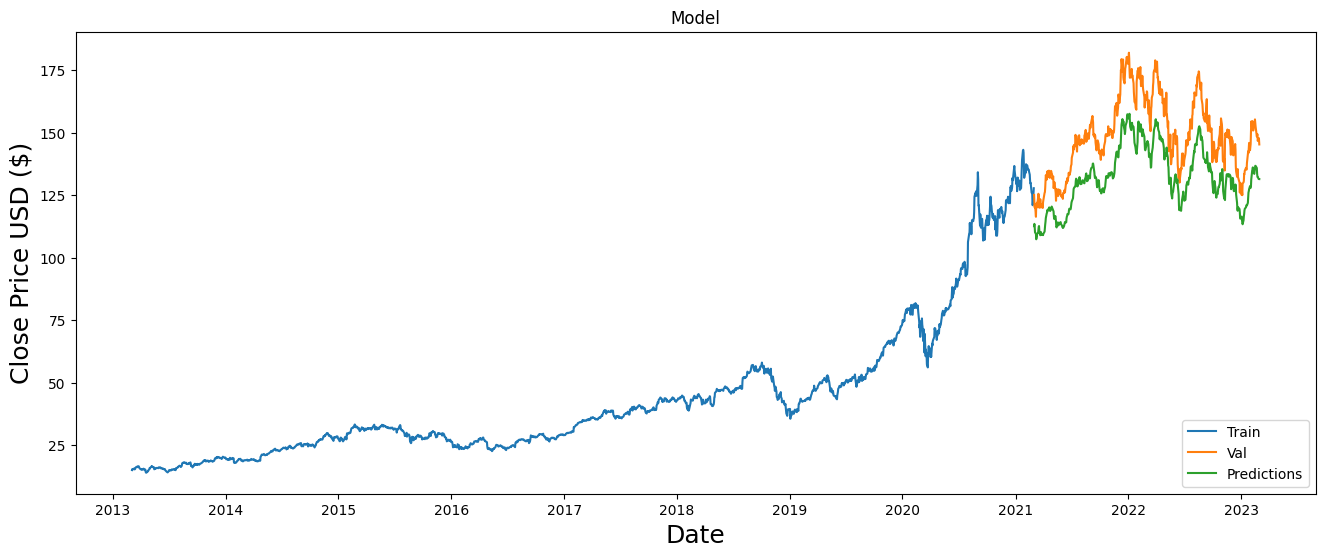

In [36]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [37]:
joblib.dump(model, 'model/model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_1
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-11 01:15:08         3068
variables.h5                                   2023-05-11 01:15:08      

['model/model.pkl']

### predicting on real time

In [21]:
end = datetime.now()
end = end - timedelta(days=3)  # for testing purposes
start = end - timedelta(days=160)
yf.pdr_override()


def get_data(ticker, start, end):
    df = pdr.get_data_yahoo('AAPL', start, end)
    return df


df = get_data('AAPL', start, end)
data = df.filter(['Close'])
data = data.iloc[len(data)-60:]
dataset = data.values
prev = data.iloc[-1].values[0]
print(data.tail())
print(prev)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)
print('before ---- ', scaled.shape)
x_pred = np.reshape(scaled, (1,scaled.shape[0], 1))
print('after ------', x_pred.shape)

# pred = model.predict(x_pred)
# pred_price = scaler.inverse_transform(pred)
# pred_price = np.reshape(pred_price, 1)[0]
# print(pred_price)


[*********************100%***********************]  1 of 1 completed
                 Close
Date                  
2023-05-01  169.589996
2023-05-02  168.539993
2023-05-03  167.449997
2023-05-04  165.789993
2023-05-05  173.570007
173.57000732421875
before ----  (60, 1)
after ------ (1, 60, 1)
